In [133]:
import argparse
import json
import logging
import pickle
import wandb

import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
import os
import numpy as np
import copy

In [134]:
import matplotlib
matplotlib.rcParams.update(
    {
        "figure.dpi": 150,
        "font.size": 20,
    }
)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [135]:
api = wandb.Api(timeout=200)

In [136]:
relabels = {
    "xppo-512-5": "xPPO",
    'tuned_xppo':'xPPO',
    "basline_stbl_ppo":'PPO-clip',
    "baseline_ppo": "PPO-clip",
    "xppo10m-512-5": "xPPO",
    "baseline_ppo_10m": "PPO-clip",
    "global_step": "Total Environment Steps",
    "rollout/ep_rew_mean": "Average Episode Reward",
    "group": "Algorithm",
    'rollout/SuccessRate':'Average Success Rate',
}

In [137]:
def load_groups(group_and_keys, relabel_dict, x_range, extra_filter):
    all_interp_data = []
    for group, x_key, y_key in group_and_keys:
        runs = api.runs(
            path="resl-mixppo/stabilized-rl",
            filters={
                "$and": [
                    {"group": group},
                    {"$not": {"tags": "exclude-from-paper"}},
                    extra_filter,
                ]
            },
        )
        print(f"Got {len(runs)} runs for group {group}")
        x_vals = np.linspace(x_range[0], x_range[1], 1000)
        for r in runs:
            # h = r.history(samples=2000, keys=[x_key, y_key])
            h = pd.DataFrame(r.scan_history(keys=[x_key, y_key]))
            try:
                interp_y = np.interp(x_vals, h[x_key], h[y_key])
            except KeyError:
                print("Could not get keys in run", r)
                print(h)
            else:
                all_interp_data.append(
                    pd.DataFrame.from_dict(
                        {
                            relabel_dict.get(x_key, x_key): x_vals,
                            relabel_dict.get(y_key, y_key): interp_y,
                            relabel_dict.get("group", "group"): relabel_dict.get(
                                group, group
                            ),
                            "run": str(r),
                        }
                    )
                )
    return pd.concat(all_interp_data, ignore_index=True)

## Pick-Place

In [138]:
env = "PickPlace-V2"
group_and_keys = [
    ("tuned_xppo", "global_step", "rollout/SuccessRate"),
]


extra_filter = {"tags": {"$in": ["xppo_pick-place"]}}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 20e6),
    extra_filter
)

Got 9 runs for group tuned_xppo


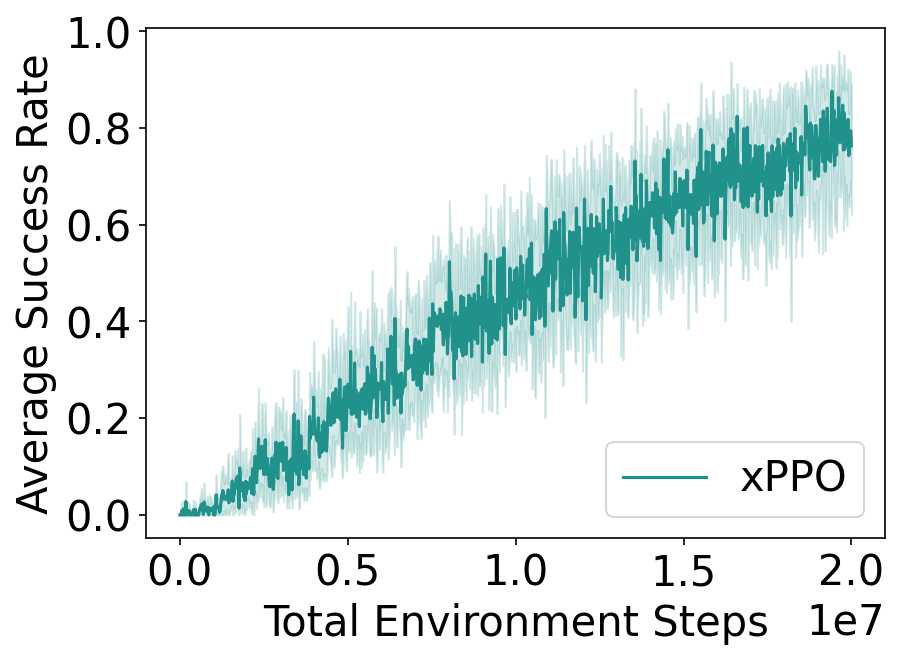

In [139]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Success Rate",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="lower right")
plt.tight_layout()

plt.savefig(f"XPPO_{env}.pdf")

In [140]:
env = "PickPlace-V2"
group_and_keys = [
    ("tuned_xppo", "global_step", "rollout/SuccessRate"),
    ("basline_stbl_ppo", 'global_step', "rollout/SuccessRate")
]

extra_filter = {"tags": {"$in": ["xppo_pick-place", 'stbl_ppo_pick-place_baseline']}}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 20e6),
    extra_filter
)

Got 9 runs for group tuned_xppo
Got 3 runs for group basline_stbl_ppo


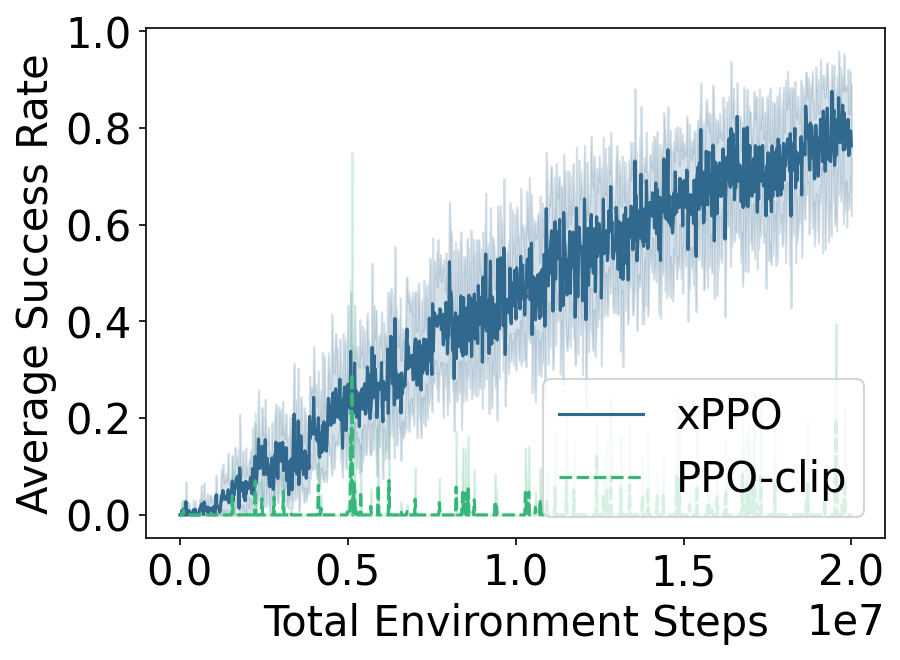

In [141]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Success Rate",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="lower right")
plt.tight_layout()

plt.savefig(f"XPPO_vs_ppo_{env}.pdf")

## Window-Open

In [142]:
env = "WindowOpen-V2"
group_and_keys = [
    ("tuned_xppo", "global_step", "rollout/SuccessRate"),
]

extra_filter = {"tags": {"$in": ["xppo_window-open"]}}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 20e6),
    extra_filter
)

Got 4 runs for group tuned_xppo


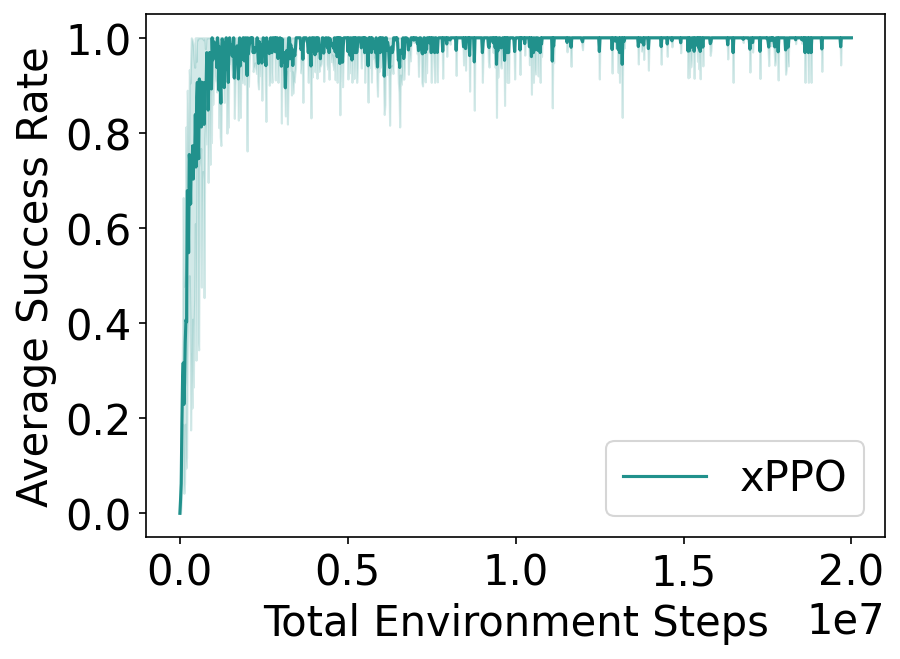

In [143]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Success Rate",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="lower right")
plt.tight_layout()

plt.savefig(f"XPPO_{env}.pdf")

In [144]:
env = "WindowOpen-V2"
group_and_keys = [
    ("tuned_xppo", "global_step", "rollout/SuccessRate"),
    ("basline_stbl_ppo", 'global_step', "rollout/SuccessRate"),
]

extra_filter = {"tags": {"$in": ["xppo_window-open", 'stbl_ppo_window-open_baseline']}}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 10e6),
    extra_filter
)

Got 4 runs for group tuned_xppo
Got 3 runs for group basline_stbl_ppo


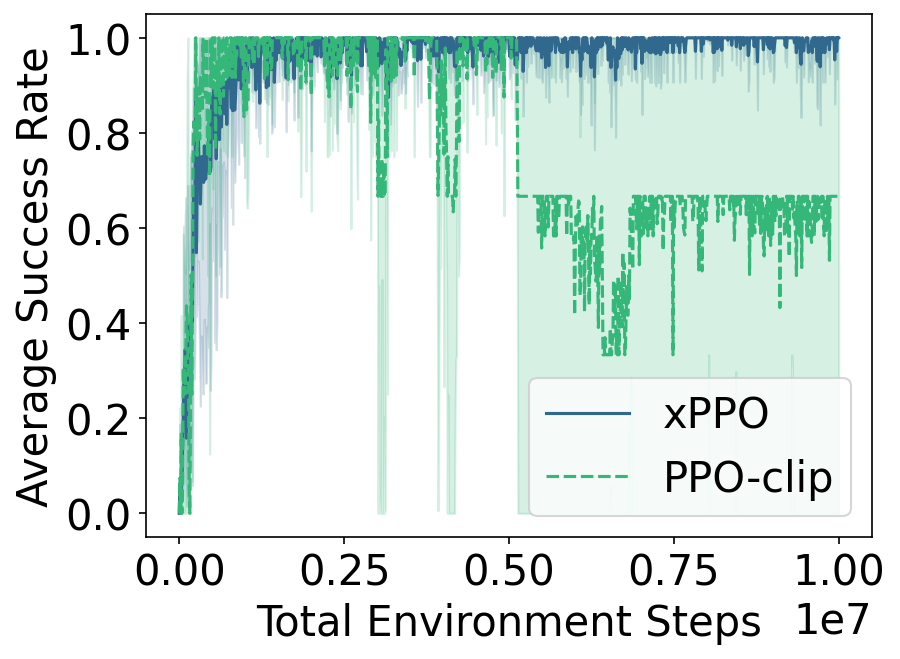

In [145]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Success Rate",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="lower right")

plt.tight_layout()
plt.tight_layout()

plt.savefig(f"XPPO_vs_ppo_{env}.pdf")

## Button-press-topdown

In [146]:
env = "ButtonPressTopdown-V2"
group_and_keys = [
    ("tuned_xppo", "global_step", "rollout/SuccessRate"),
]

extra_filter = {"tags": {"$in": ["xppo_button-press-topdown"]}}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 7e6),
    extra_filter
)

Got 9 runs for group tuned_xppo


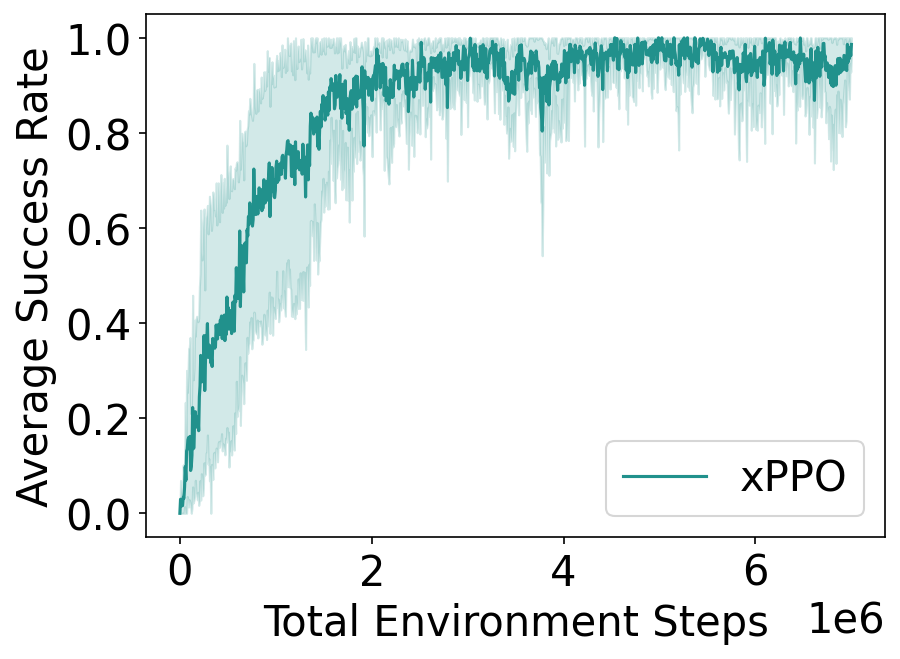

In [147]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Success Rate",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="lower right")
plt.tight_layout()

plt.savefig(f"XPPO_{env}.pdf")

In [148]:
env = "ButtonPressTopdown-V2"
group_and_keys = [
    ("tuned_xppo", "global_step", "rollout/SuccessRate"),
    ("basline_stbl_ppo", 'global_step', "rollout/SuccessRate"),   
]

extra_filter = {"tags": {"$in": ["xppo_button-press-topdown", 'stbl_ppo_button-press-topdown_baseline']}}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 7e6),
    extra_filter
)

Got 9 runs for group tuned_xppo
Got 3 runs for group basline_stbl_ppo


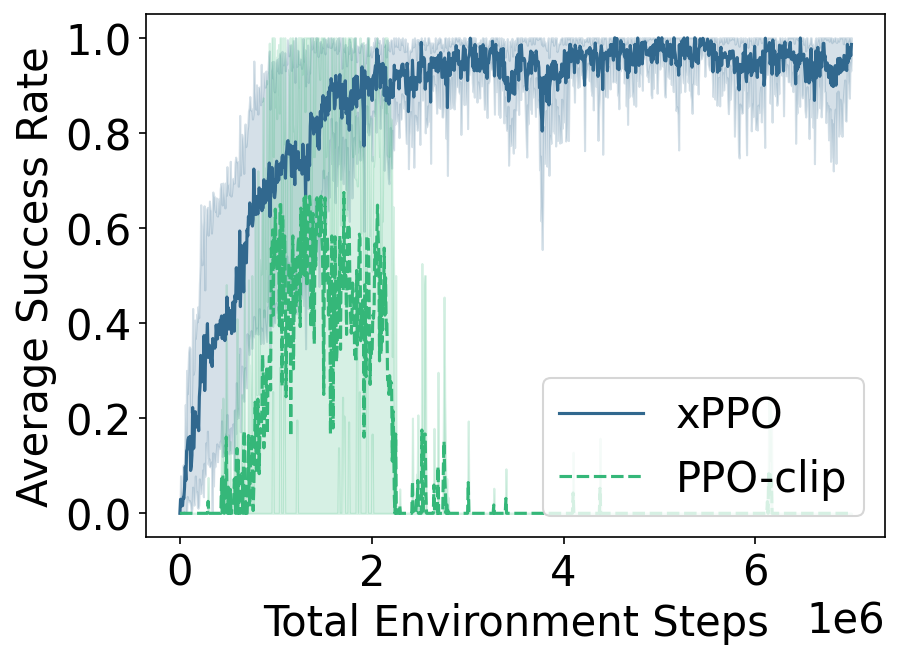

In [149]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Success Rate",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="lower right")
plt.tight_layout()

plt.savefig(f"XPPO_vs_ppo_{env}.pdf")

## Reach

In [150]:
env = "Reach-V2"
group_and_keys = [
    ("tuned_xppo", "global_step", "rollout/SuccessRate"),
]

extra_filter = {"tags": {"$in": ["xppo_reach"]}}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 20e6),
    extra_filter
)

Got 3 runs for group tuned_xppo


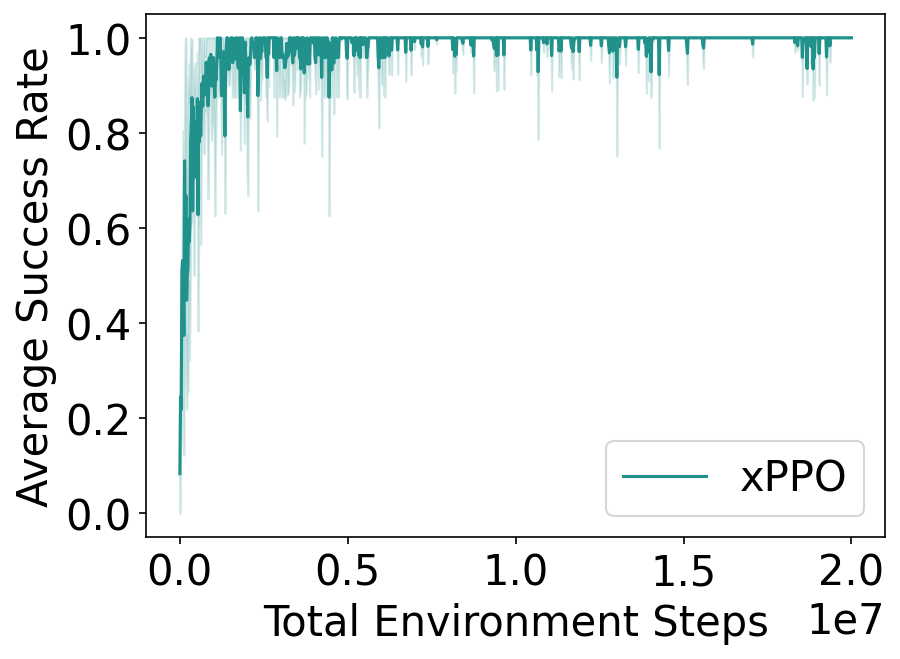

In [151]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Success Rate",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(f"XPPO_{env}.pdf")

In [152]:
env = "Reach-V2"
group_and_keys = [
    ("tuned_xppo", "global_step", "rollout/SuccessRate"),
    ("basline_stbl_ppo", 'global_step', "rollout/SuccessRate"),   
]

extra_filter = {"tags": {"$in": ["xppo_reach", 'stbl_ppo_reach_baseline']}}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 10e6),
    extra_filter
)

Got 3 runs for group tuned_xppo
Got 3 runs for group basline_stbl_ppo


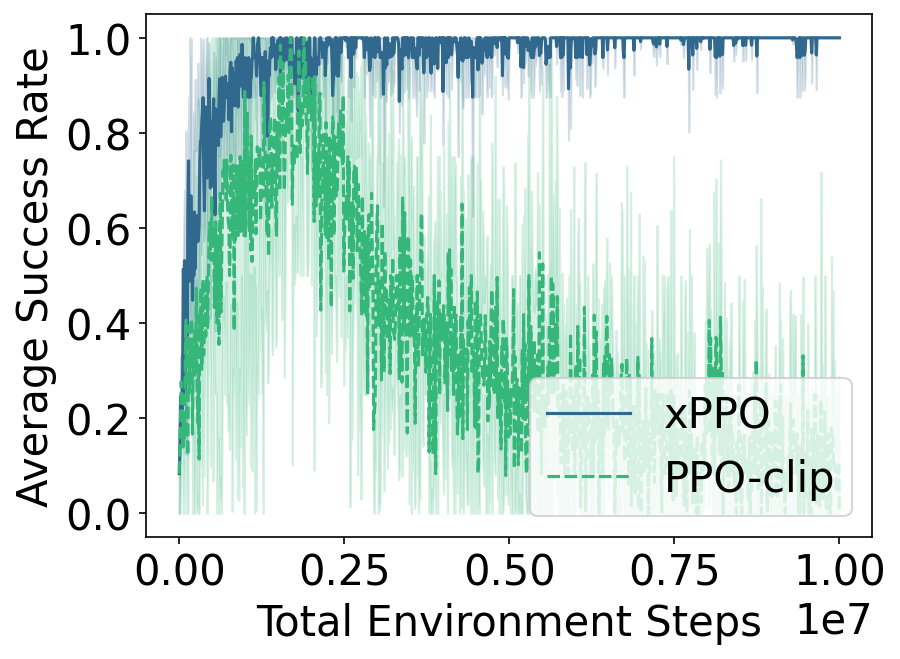

In [153]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Success Rate",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(f"XPPO_vs_ppo_{env}.pdf")